# Importing packages 

In [ ]:
# Importing packages import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import shutil, sys 
from keras.layers import Conv2D,MaxPool2D,GlobalAveragePooling2D,AveragePooling2D
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import cv2
from keras.preprocessing import image


from tqdm import tqdm_notebook
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda, Dense, Flatten,BatchNormalization
from keras.models import load_model, Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

#  Data Preparation

In [ ]:
print(len(os.listdir('/content/drive/Drive/Kaggle/cats_dogs_data/PetImages/Cat')))
print(len(os.listdir('/content/drive/Drive/Kaggle/cats_dogs_data/PetImages/Dog')))

12501
12500


In [ ]:
#The path to the folder containing the folders "dogs" & "cats"
path = '/content/drive/Drive/Kaggle/cats_dogs_data/PetImages' 
    
path_dogs = os.path.join(path, 'Dog')  
path_cats = os.path.join(path, 'Cat')   

In [ ]:
# Creation of the new "cats_dogs" directory to do another image distribution
root_dir = '/content/drive/Drive/Kaggle/cats_dogs'

# Empty directory to prevent FileExistsError if the function is executed several times
if os.path.exists(root_dir):
    shutil.rmtree(root_dir)

"create_train_valid" function creates two folders for the "training" and for the "validation" in the directory "cats_dogs", appeès in each of these folders we will create two other folders whose first contains the "dogs" images and the other the "cats" images

In [ ]:
def create_train_valid(root_path):
    os.mkdir(root_path)
    train_dir = os.path.join(root_path, 'training')
    os.mkdir(train_dir)
    val_dir = os.path.join(root_path, 'validation')
    os.mkdir(val_dir)
    cat_train_dir = os.path.join(train_dir, 'cats')
    os.mkdir(cat_train_dir)
    dog_train_dir = os.path.join(train_dir, 'dogs')
    os.mkdir(dog_train_dir)

    cat_val_dir = os.path.join(val_dir, 'cats')
    os.mkdir(cat_val_dir)
    dog_val_dir = os.path.join(val_dir, 'dogs')
    os.mkdir(dog_val_dir)


In [ ]:
# Test the create_train_valid function 
for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/content/drive/MyDrive/Kaggle/cats_dogs_dats/training
/content/drive/MyDrive/Kaggle/cats_dogs_dats/validation
/content/drive/MyDrive/Kaggle/cats_dogs_dats/training/cats
/content/drive/MyDrive/Kaggle/cats_dogs_dats/training/dogs
/content/drive/MyDrive/Kaggle/cats_dogs_dats/validation/cats
/content/drive/MyDrive/Kaggle/cats_dogs_dats/validation/dogs


"split_data" function creates the train base (random images will be selected from (cats+dogs) and from our test base in the same way)

In [ ]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
    source_list = os.listdir(SOURCE_DIR)
    train_list = random.sample(source_list, int(len(source_list)*SPLIT_SIZE))
    for img in source_list:
        if os.path.getsize(os.path.join(SOURCE_DIR, img)) == 0:
            print(img + "is zero length, so ignoring.")
        elif img in train_list:
            copyfile(os.path.join(SOURCE_DIR, img), os.path.join(TRAINING_DIR, img))
        else:
            copyfile(os.path.join(SOURCE_DIR, img), os.path.join(VALIDATION_DIR, img))

In [ ]:
# Define the access paths 
CAT_SOURCE_DIR = "/content/drive/MyDrive/Kaggle/cats_dogs_data/PetImages/Cat"
DOG_SOURCE_DIR = "/content/drive/MyDrive/Kaggle/cats_dogs_data/PetImages/Dog"

TRAINING_DIR = "/content/drive/MyDrive/Kaggle/cats_dogs_dats/training"
VALIDATION_DIR = "/content/drive/MyDrive/Kaggle/cats_dogs_dats/validation"

TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "cats/") 
VALIDATION_CATS_DIR = os.path.join(VALIDATION_DIR, "cats/")

TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS_DIR = os.path.join(VALIDATION_DIR, "dogs/")

In [ ]:
# Empty directories in case we run this cell several times
if len(os.listdir(TRAINING_CATS_DIR)) > 0:
    for file in os.scandir(TRAINING_CATS_DIR):
        os.remove(file.path)
if len(os.listdir(TRAINING_DOGS_DIR)) > 0:
    for file in os.scandir(TRAINING_DOGS_DIR):
        os.remove(file.path)
if len(os.listdir(VALIDATION_CATS_DIR)) > 0:
    for file in os.scandir(VALIDATION_CATS_DIR):
        os.remove(file.path)
if len(os.listdir(VALIDATION_DOGS_DIR)) > 0:
    for file in os.scandir(VALIDATION_DOGS_DIR):
        os.remove(file.path)

split_size = .9 #the proportion of images used for the train

In [ ]:
# create train and test data
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, VALIDATION_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, VALIDATION_DOGS_DIR, split_size)

# Check that the number of images corresponds to the expected output
print(f"\n\nLe répertoire d'origine cats contient {len(os.listdir(CAT_SOURCE_DIR))} images")
print(f"Le répertoire d'origine dogs contient {len(os.listdir(DOG_SOURCE_DIR))} images\n")

# Training and validation splits
print(f"Il y a {len(os.listdir(TRAINING_CATS_DIR))} images cats pour le training")
print(f"Il y a {len(os.listdir(TRAINING_DOGS_DIR))} images dogs pour le training")
print(f"Il y a {len(os.listdir(VALIDATION_CATS_DIR))} images cats pour la validation")
print(f"Il y a {len(os.listdir(VALIDATION_DOGS_DIR))} images dogs pour la validation")

666.jpgis zero length, so ignoring.
11702.jpgis zero length, so ignoring.


Le répertoire d'origine cats contient 12501 images
Le répertoire d'origine dogs contient 12500 images

Il y a 11249 images cats pour le training
Il y a 11249 images dogs pour le training
Il y a 1251 images cats pour la validation
Il y a 1250 images dogs pour la validation


In [ ]:
def train_valid_generators(TRAINING_DIR, VALIDATION_DIR):
    train_data_gen = ImageDataGenerator(rescale=1/255,            #Transform each pixel value from [0.255] to [0.1]
                                       
                                       horizontal_flip = True, fill_mode = 'nearest')   #flip images horizontally
                                       
    train_generator = train_data_gen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=20,       #Producing 20 images at each train iteration.
                                                        
                                                      class_mode='binary',       #we have only two classes
                                                        
                                                      target_size=(150, 150))    #the size of the images will be 150*150

    validation_data_gen = ImageDataGenerator(rescale=1/255, horizontal_flip = True, fill_mode = 'nearest')
   
    validation_generator = validation_data_gen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=20, class_mode='binary', target_size=(150, 150))     
    return train_generator, validation_generator

In [ ]:
#Testing the function
train_generator, validation_generator = train_valid_generators(TRAINING_DIR, VALIDATION_DIR)

Found 22497 images belonging to 2 classes.
Found 2501 images belonging to 2 classes.


# Modeling  

## **EarlyStopping**

In [ ]:
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(patience=5,     #After 5 iterations if there is no improvement we stop the training
                          verbose=1, mode='auto')    

In [ ]:
callbacks = [earlystop]

# **CNN : 4 convolutional layers**

###### Creating the model : 

In [ ]:
def create_model():
    model = tf.keras.models.Sequential([ 
        Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),  #16 filters, (3,3) kernal size (width & height),
                                                                          #input shape 150*150 image size with 3 colors. 
        MaxPooling2D(2,2), #(2, 2) (vertical, horizontal), will halve the image in each dimension
        
        Conv2D(32, (3,3), activation='relu'), # 32 filters
        MaxPooling2D(2,2), 
        
        Conv2D(64, (3,3), activation='relu'), #64 filters
        MaxPooling2D(2,2),
        
        Conv2D(128, (3,3), activation='relu'), #128 filters
        MaxPooling2D(2,2),
        
        # Flatten the results to feed the deep neural network
        tf.keras.layers.Flatten(), 
        
        # 512 neuron hidden layer
        Dense(512, activation='relu'), 
        
        #Only 1 output neuron. It will contain a value of 0 to 1 where 0 for class ('cats') and 1 for class ('dogs')
        Dense(1, activation='sigmoid')
      ])
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy']) 

    return model

In [ ]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

###### Training the model :

In [ ]:
history = model.fit(train_generator,  #Train data
                    epochs=30, verbose=1,
                    validation_data=validation_generator, 
                    callbacks=callbacks)

Epoch 1/30
 662/1125 [================>.............] - ETA: 49s - loss: 0.6410 - accuracy: 0.6160

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWar

1125/1125 [==============================] - 137s 113ms/step - loss: 0.6054 - accuracy: 0.6567 - val_loss: 0.5335 - val_accuracy: 0.7285
Epoch 2/30
1125/1125 [==============================] - 120s 107ms/step - loss: 0.4633 - accuracy: 0.7787 - val_loss: 0.4181 - val_accuracy: 0.8097
Epoch 3/30
1125/1125 [==============================] - 119s 106ms/step - loss: 0.3758 - accuracy: 0.8315 - val_loss: 0.3552 - val_accuracy: 0.8385
Epoch 4/30
1125/1125 [==============================] - 120s 107ms/step - loss: 0.3212 - accuracy: 0.8608 - val_loss: 0.3482 - val_accuracy: 0.8513
Epoch 5/30
1125/1125 [==============================] - 119s 106ms/step - loss: 0.2764 - accuracy: 0.8830 - val_loss: 0.3176 - val_accuracy: 0.8617
Epoch 6/30
1125/1125 [==============================] - 121s 107ms/step - loss: 0.2462 - accuracy: 0.8970 - val_loss: 0.3396 - val_accuracy: 0.8629
Epoch 7/30
1125/1125 [==============================] - 119s 106ms/step - loss: 0.2142 - accuracy: 0.9104 - val_loss: 0.280

The CNN model provided an accuracy of 90.56%

In [ ]:
acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']
loss = history.history['loss']
valid_loss = history.history['val_loss']

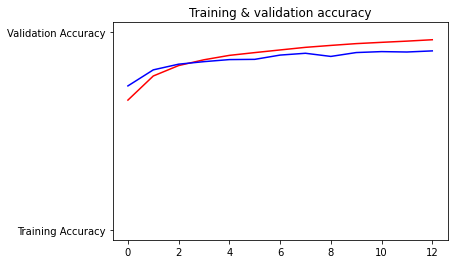

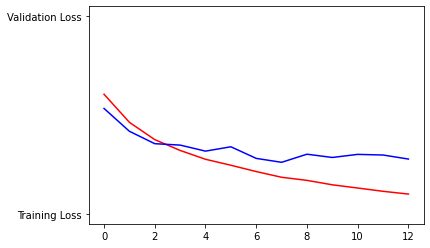

In [ ]:
epochs = range(len(acc)) 

# View training & validation precision by epoch
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, valid_acc, 'b', "Validation Accuracy")
plt.title('Training & validation accuracy')
plt.show()
print("")

# view training & validation loss by epoch
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, valid_loss, 'b', "Validation Loss")
plt.show()

# **VGG-16 Model**

In [ ]:
vgg16_model = VGG16(weights = 'imagenet', #'imagenet' indicates that we want to use weights pre-trained for the respective model
                    include_top = False)  #'include_top=False' loads a network that does not include top classification layers
            
x = vgg16_model.output   # x contains outputs from the vgg-16 model 

# we make subsampling by averaging the height and width dimensions of the input.
x = GlobalAveragePooling2D()(x)       
    
# we add a hidden layer of 1024 neurons and a "relu" function for activation
x = Dense(1024, activation='relu')(x)  

predictions = Dense(1, activation = 'sigmoid')(x) #An output layer gives a binary classification (2 outputs)
    
model1 = Model(inputs = vgg16_model.input, outputs = predictions)  

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
# freeze all layers of the pre-trained and trained model
for layer in vgg16_model.layers:
    layer.trainable = False

In [ ]:
model1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [ ]:
model1.compile(optimizer = 'adam', # Compile the new model using an "adam" optimizer
    loss = 'binary_crossentropy',  # binary classification 
    metrics = ['accuracy'])

In [ ]:
# fit the model
vgg16_history = model1.fit_generator(
    train_generator,
    epochs = 30,
    validation_data = validation_generator,
    callbacks=callbacks)

Epoch 1/30


<ipython-input-60-b19e0c8e7142>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  vgg16_history = model1.fit_generator(


   3/1125 [..............................] - ETA: 1:41 - loss: 0.6391 - accuracy: 0.5667

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWar

1125/1125 [==============================] - 146s 128ms/step - loss: 0.2730 - accuracy: 0.8828 - val_loss: 0.2471 - val_accuracy: 0.8988
Epoch 2/30
1125/1125 [==============================] - 132s 117ms/step - loss: 0.2338 - accuracy: 0.8991 - val_loss: 0.2565 - val_accuracy: 0.8948
Epoch 3/30
1125/1125 [==============================] - 130s 116ms/step - loss: 0.2202 - accuracy: 0.9050 - val_loss: 0.2394 - val_accuracy: 0.8996
Epoch 4/30
1125/1125 [==============================] - 132s 117ms/step - loss: 0.2067 - accuracy: 0.9103 - val_loss: 0.2536 - val_accuracy: 0.8916
Epoch 5/30
1125/1125 [==============================] - 132s 117ms/step - loss: 0.1987 - accuracy: 0.9166 - val_loss: 0.2297 - val_accuracy: 0.9000
Epoch 6/30
1125/1125 [==============================] - 131s 116ms/step - loss: 0.1889 - accuracy: 0.9207 - val_loss: 0.2421 - val_accuracy: 0.9032
Epoch 7/30
1125/1125 [==============================] - 131s 116ms/step - loss: 0.1806 - accuracy: 0.9227 - val_loss: 0.232

The VGG-16 model provided 90.44% accuracy

In [ ]:
acc_vgg16=vgg16_history.history['accuracy']
valid_acc_vgg16=vgg16_history.history['val_accuracy']

loss_vgg16=vgg16_history.history['loss']
valid_loss_vgg16=vgg16_history.history['val_loss']

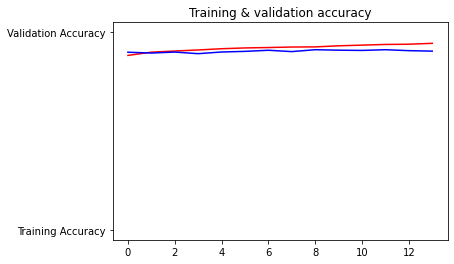

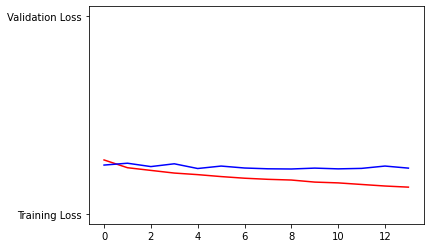

In [ ]:
epochs = range(len(acc_vgg16)) 

# view training & validation accuracy per epoch
plt.plot(epochs, acc_vgg16, 'r', "Training Accuracy")
plt.plot(epochs, valid_acc_vgg16, 'b', "Validation Accuracy")
plt.title('Training & validation accuracy')
plt.show()

# view training & validation loss per epoch
plt.plot(epochs, loss_vgg16, 'r', "Training Loss")
plt.plot(epochs, valid_loss_vgg16, 'b', "Validation Loss")
plt.show()

#  Predictions on downloaded images

### Viewing Images

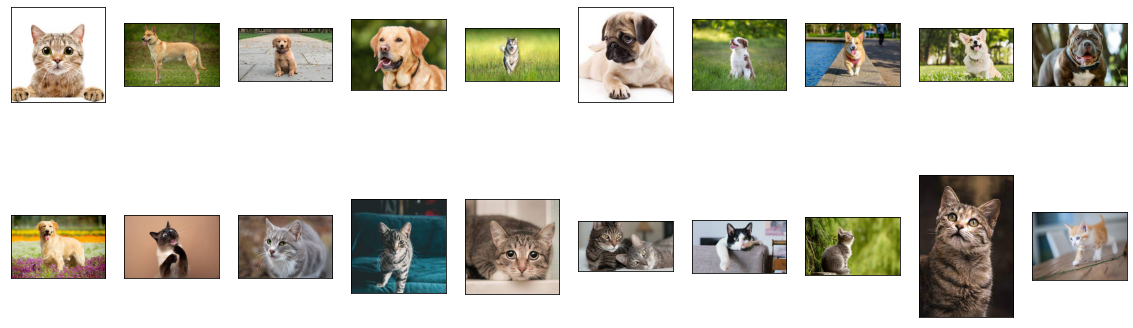

In [ ]:
import glob
import matplotlib.image as mpimg
%matplotlib inline

images = []
for img_path in glob.glob('/content/drive/Drive/Kaggle/images_prediction/*.jpg'):
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(20,10))
columns = 10
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)

In [ ]:
import numpy as np

images = []
for img in os.listdir('/content/drive/Drive/Kaggle/images_prediction'):
    img = os.path.join('/content/drive/Drive/Kaggle/images_prediction', img)
    img = tf.keras.utils.load_img(img, target_size=(150, 150))
    img = tf.keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    images.append(img)

images = np.vstack(images) # stack the list of images to pass for prediction

## Prediction with CNN with 4 convolutional layers

In [ ]:
classes = model.predict(images)
print(classes)

2/2 [==============================] - 0s 8ms/step
[[0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]]


* CNN’s model failed to predict 2 cats correctly, it classes them as dogs.
* All dogs are well predicted.

## Prediction with VGG-16

In [ ]:
classes_vgg16 = model1.predict(images)
print(classes_vgg16)

2/2 [==============================] - 0s 53ms/step
[[0.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [2.7570536e-14]
 [0.0000000e+00]
 [0.0000000e+00]]


* The VGG-16 failed to classify only one cat.
* All dogs correctly.